# # TODO
* Write README for GitHub
* Write KS test example
* Guiding through project



# Santander Customer Transaction Prediction
### Table of Contents
  * [Introduction](#section_1)
  * [Preparing the data](#section_2)
  * [Exploratory data analysis](#section_3)
    * [Balance of class](#section_3.1)
    * [Difference in feature distribution with K-S test](#section_3.2)
  * [LightGBM model](#section_4)
  * [Comparing feature importance to differences in the distribution](#section_5)


<a id='section_1'></a>
## Introduction
This data set is provided by Santander in the Kaggle competition 'Santander Customer Transaction Prediction -
can you identify who will make a transaction?'. The project's goal is to solve a binary classification. Based on 200 variables found in the data set, we try to identify which customer will make a specific transaction in the future. All variables are anonymized numeric features, with a column for the `ID_code` and an additional column for the `target` in the train set.


Importing packages

In [35]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier

import time
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp
print('Packages Loaded.')


Packages Loaded.


Loading the data.

In [36]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
print('Loading test and train dataset.')

Loading test and train dataset.


<a id='section_2'></a>
## Preparing the data

The train and test set are of the same size, with the addition of a target column in the train set.

In [37]:
train.keys()
test.keys()
print('Shape of the test set:\n{},\nShape of the train set:\n{}'.format(test.shape, 
                                                                        train.shape))

Shape of the test set:
(200000, 201),
Shape of the train set:
(200000, 202)


In [38]:
unique_variable = None
for i in train.keys():
    if i in test.keys():
        continue
    else:
        unique_variable = i
print('Unique variable to the train set:\n{}'.format(unique_variable))


Unique variable to the train set:
target


Looking for missing values in the train and test data.

In [39]:
print('Missing values in the test set:\n{}\n\nMissing values in the train set:\n{}'
      .format(test.isnull().sum().sum(), train.isnull().sum().sum()))


Missing values in the test set:
0

Missing values in the train set:
0


Splitting the train data into a train and test set, to evaluate our predictions.

In [40]:
# train and test sets
X = train.iloc[:, 2:]
y = train.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=121)

<a id='section_3'></a>
## EDA

<a id='section_3.1'></a>
### Balance of classes
  
Looking at the balance of classes, we can see that there is an imbalance between cases of transactions (target = 1)
 and cases of no transactions (target = 0). This is important to know, as a a dummy prediction that would predict a
 target value of 0 for every case, would be correct in about 90% of cases. But as the target values of the test data are
 unknown, we can not assume that the same imbalance of classes is present in the test data.

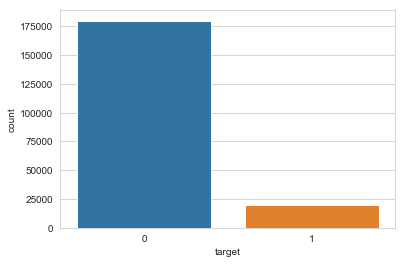

10.049% of target values are of value 1.


In [41]:
sns.countplot(train['target'])
plt.show()
print('{}% of target values are of value 1.'.format(100*train['target'].value_counts()[1]/train.shape[0]))


<a id='section_3.2'></a>
### Difference in feature distribution with K-S test


In [42]:
def plot_Features(df1, df2, train_features):
    i = 0
    plt.figure(figsize=(16,10))
    for feature in train_features:
        i += 1
        plt.subplot(6, 2, i)
        sns.distplot(df1[feature], color='orange', hist=False, label='target = 1')
        sns.distplot(df2[feature], color='blue', hist=False, label='test = 0')
        ks = ks_2samp(df1[feature], df2[feature])
        plt.xlabel(feature + '    K-S ststistic:' + str(round(ks[0],4)))
        plt.subplots_adjust(hspace=0.6)
        plt.legend()
    plt.show()

In [43]:
x = train.loc[train['target'] == 1]
y = train.loc[train['target'] == 0]
features = ['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
            'var_8', 'var_9', 'var_10', 'var_11']

 
Plotting the distributions of the first 12 variables in the test set, grouped by the target value.
 
We can see that there are varying differences in the distributions of the features. Some are more closely distributed, while others show distinct differences in the distribution.


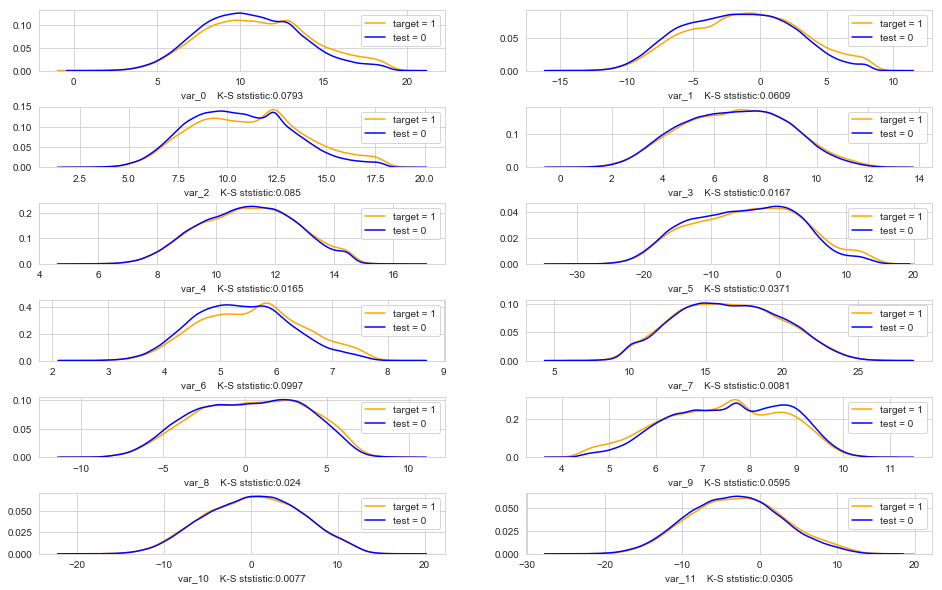

In [44]:
plot_Features(x, y, features)


Using the two sample Kolmogorov-Smirnov test (K-S test), we can measure the differences between distributions. Ranking the features by the K-S statistic, gives us a sense of which features show a larger variation in their distribution.


In [45]:
#computing the K-S statistic for the features
ks_rank = pd.DataFrame(columns=('feature', 'ks_statistic'))
features = train.columns.values[2:202]
for feature in features:
    ks = ks_2samp(x[feature], y[feature])
    ks_dict = {}
    ks_dict = {'feature' : feature, 'ks_statistic' : ks[0]}
    ks_rank = ks_rank.append(ks_dict, ignore_index=True)

ks_rank.sort_values(by='ks_statistic', ascending=False, inplace=True)
ks_rank.reset_index(inplace=True)


In [46]:
def plot_ks(df1, df2, features, ticks=False):
    ks_rank_int = pd.DataFrame(columns=('feature', 'ks_statistic'))
    for feat in features:
        ks_int = ks_2samp(df1[feat], df2[feat])
        ks_dict_int = {}
        ks_dict_int = {'feature' : feat, 'ks_statistic' : ks_int[0]}
        ks_rank_int = ks_rank_int.append(ks_dict_int, ignore_index=True)
    ks_rank_int.sort_values(by='ks_statistic', ascending=False, inplace=True)
    plt.figure(figsize=(16, 5))
    sns.barplot(x='feature', y='ks_statistic', data=ks_rank_int)
    plt.title('Feature rank by K-S statistic')
    if ticks == False:
        plt.xticks([])
    plt.show()

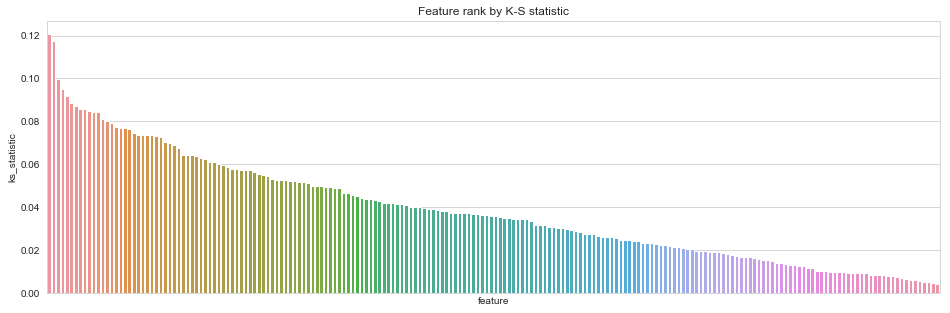

In [47]:
features = train.columns.values[2:202]
plot_ks(x, y, features)


Top 10 features by K-S statistic


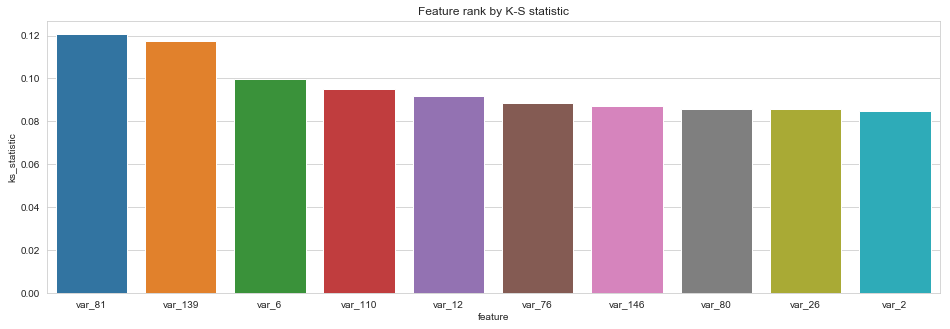

In [48]:
features = ks_rank.loc[:9, 'feature'].values

plot_ks(x, y, features, ticks=True)

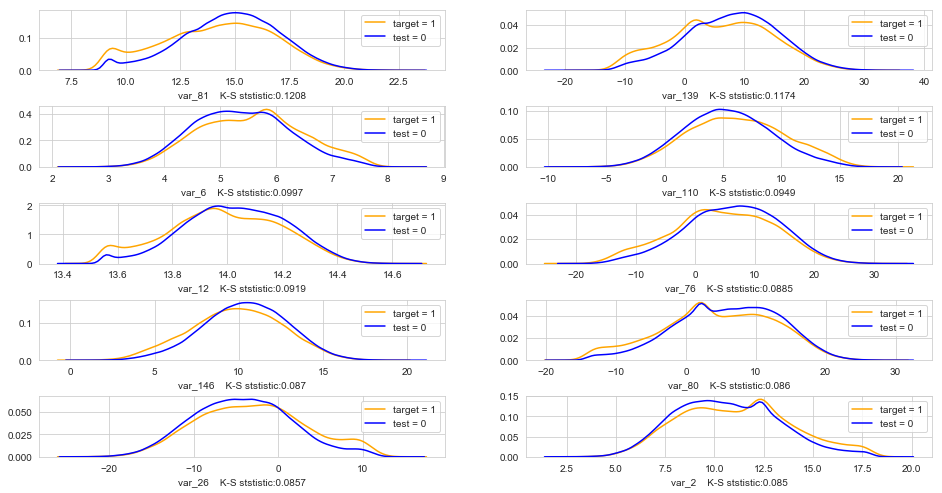

In [49]:
plot_Features(x, y, features)

Bottom 10 features by K-S statistic


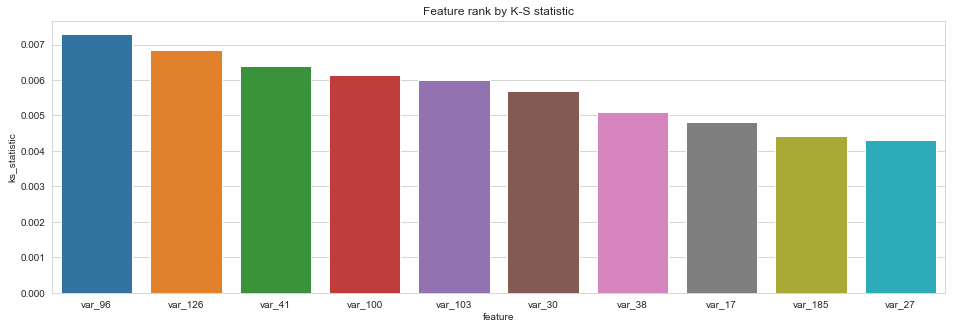

In [50]:
features = ks_rank.loc[190:, 'feature'].values
plot_ks(x, y, features, ticks=True)

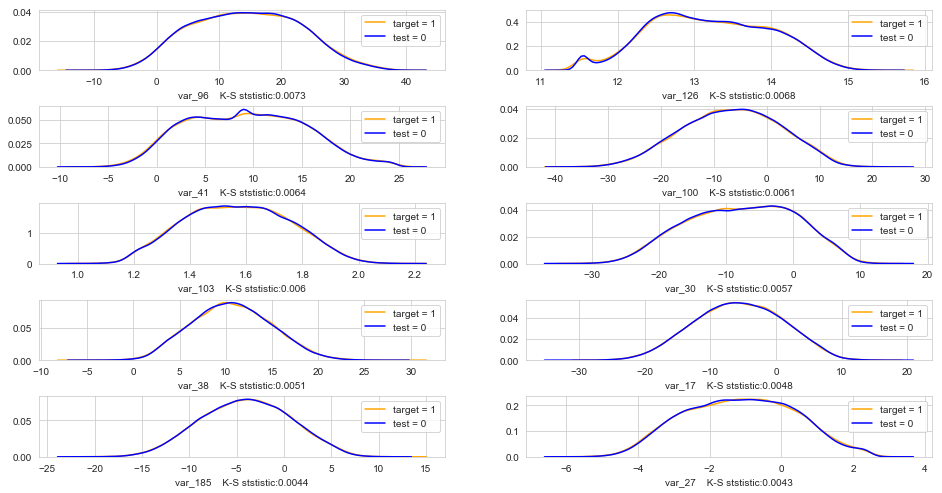

In [51]:
plot_Features(x, y, features)

    
    
We can use the K-S test to take a look at the train and test set, and see if the features share a common distribution.

In [52]:
ks_rank2 = pd.DataFrame(columns=('feature', 'ks_statistic'))
features = train.columns.values[2:202]
for feature in features:
    ks = ks_2samp(train[feature], test[feature])
    ks_dict = {}
    ks_dict = {'feature' : feature, 'ks_statistic' : ks[0]}
    ks_rank2 = ks_rank2.append(ks_dict, ignore_index=True)

ks_rank2.sort_values(by='ks_statistic', ascending=False, inplace=True)
ks_rank2.reset_index(inplace=True)


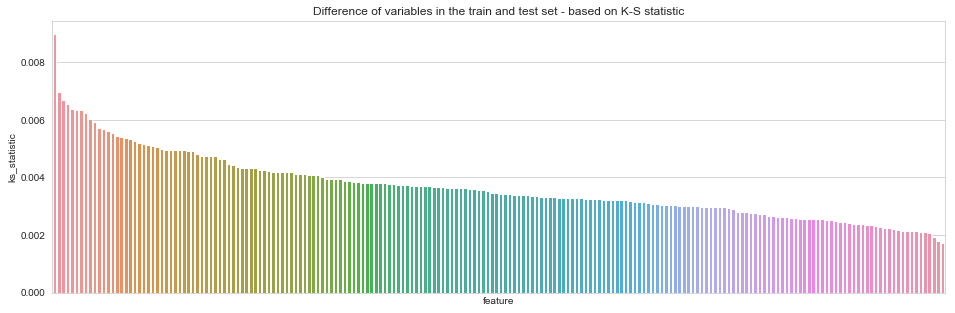

In [53]:
plt.figure(figsize=(16, 5))
plt.title('Difference of variables in the train and test set - based on K-S statistic')
sns.barplot(x='feature', y='ks_statistic', data=ks_rank2)
plt.xticks([])
plt.show()


Distribution of mean values for the train and test set.


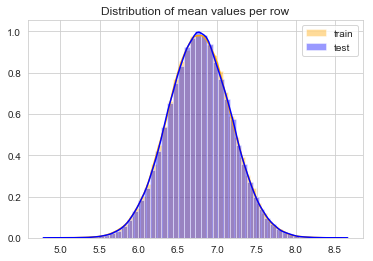

In [54]:
features = train.columns.values[2:202]
plt.figure()
plt.title('Distribution of mean values per row')
sns.set_style('whitegrid')
sns.distplot(train[features].mean(axis=1), color='orange', kde=True, label='train')
sns.distplot(test[features].mean(axis=1), color='blue', kde=True, label='test')
plt.legend()
plt.show()


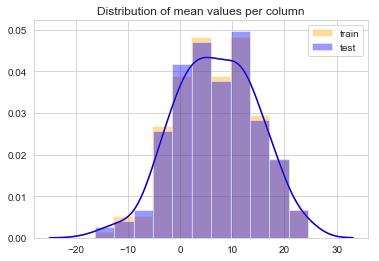

In [55]:
plt.figure()
plt.title('Distribution of mean values per column')
sns.set_style('whitegrid')
sns.distplot(train[features].mean(axis=0), color='orange', kde=True, label='train')
sns.distplot(test[features].mean(axis=0), color='blue', kde=True, label='test')
plt.legend()
plt.show()


<a id='section_4'></a>
### LightGBM Model


Setting parameters for the LightGBM classifier.


In [65]:
# parameters for lgb
lgb_params = {'max_depth' :3,
              'boost_from_average' : 'false',
              'min_data_in_leaf' : 80,
              'feature_fraction' : 1,
              'bagging_fraction' :0.5,
              'bagging_freq' : 2,
              'learning_rate' : 0.01,
              'min_gain_to_split' : 0.07,
              'min_sum_hessian_in_leaf' : 10,
              'num_leaves' : 30,
              'metric' : 'auc',
              'objective' : 'binary',}


Training the lgbm model.

In [57]:
start = time.time()
X_tr = lgb.Dataset(X_train, label=y_train)
X_val = lgb.Dataset(X_test, label=y_test)

clf_lgb = lgb.train(lgb_params, X_tr, 1000000, valid_sets = [X_val], verbose_eval=-1, 
                    early_stopping_rounds=3000)

end = time.time()
print('%.2f'%(end-start))

Training until validation scores don't improve for 3000 rounds.
Early stopping, best iteration is:
[12102]	valid_0's auc: 0.899902
270.03


Evaluate roc-auc-score for the model.

In [58]:
%%time
y_pred = clf_lgb.predict(X_test, num_iteration=clf_lgb.best_iteration)

print('CV score: {:<8.5f}'.format(roc_auc_score(y_test, y_pred)))

CV score: 0.89990 
Wall time: 12.8 s


In [82]:
df_importances = pd.DataFrame()
df_importances['feature'] = features
df_importances['importance'] = clf_lgb.feature_importance()
df_importances.sort_values(by='importance', ascending=False, inplace=True)
df_importances.reset_index(inplace=True)


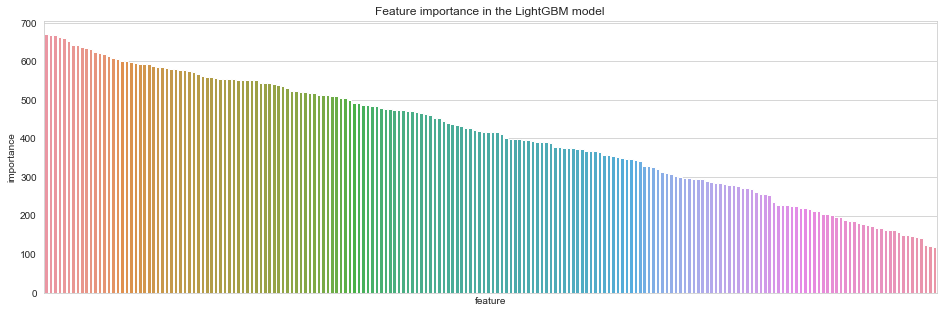

In [60]:
plt.figure(figsize=(16, 5))
plt.title('Feature importance in the LightGBM model')
sns.barplot(x='feature', y='importance', data=df_importances)
plt.xticks([])
plt.show()


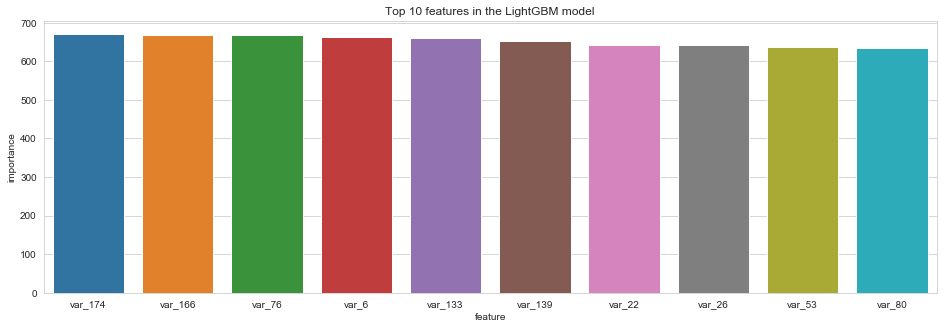

In [61]:
plt.figure(figsize=(16, 5))
plt.title('Top 10 features in the LightGBM model')
sns.barplot(x='feature', y='importance', data=df_importances.head(10))
plt.show()


Score achieved: 0.89788

<a id='section_5'></a>
### Comparing feature importance to differences in the distribution

In [109]:
feat_name = list()
lgbm_importance = list()
for i in ks_rank['feature'].head(10):
    feat_name.append(i)
    lgbm_importance.append(df_importances.loc[df_importances['feature'] == i].index[0])
display(pd.DataFrame({'LightGBM_rank' :lgbm_importance, 'ks_rank' : np.arange(1, 11)}, feat_name))


,LightGBM_rank,ks_rank
var_81,12,1
var_139,5,2
var_6,3,3
var_110,23,4
var_12,21,5
var_76,2,6
var_146,11,7
var_80,9,8
var_26,7,9
var_2,19,10


Comparing the features previously ranked by their difference in the cummulative distribution, it is interesting to see that these features have a high importance in our LightGBM model.

In [111]:
feat_name = list()
lgbm_importance = list()
for i in ks_rank['feature'].tail(10):
    feat_name.append(i)
    lgbm_importance.append(df_importances.loc[df_importances['feature'] == i].index[0])
display(pd.DataFrame({'LightGBM_rank' :lgbm_importance, 'ks_rank' : np.arange(191, 201)}, feat_name))


,LightGBM_rank,ks_rank
var_96,186,191
var_126,180,192
var_41,179,193
var_100,190,194
var_103,188,195
var_30,187,196
var_38,194,197
var_17,195,198
var_185,197,199
var_27,176,200


Furthermore, we can observe that the more similar distributed features are also ranked low in feature importance.

<a id='section_5'></a>
Createing submission file.
  
Score on submission: 0.89788


In [62]:
test_features = test.drop('ID_code', axis=1)

y_sub = clf_lgb.predict(test_features, num_iteration=clf_lgb.best_iteration)


In [63]:
submission = pd.DataFrame({'ID_code' : test['ID_code'], 'target' : y_sub})
submission.to_csv('submission.csv', index=False)

